# Slow/Fast spindles differentiation

This notebook demonstrates several ways to differentiate between slow and fast spindles using YASA. Notably, we will see many ways to detect the peak frequencies of these two types of spindles. But, first, a primer on the distinction between these two types of spindles:

From [Cox et al. 2017](https://www.frontiersin.org/articles/10.3389/fnhum.2017.00433/full):

> Although  the  formal  definition  treats  spindles  as  an undifferentiated category restricted to the 11–16 Hz range (most commonly 12–14 Hz; Iber et al., 2007), substantial evidence suggests that spindles can be classified as either slow (∼10 Hz) or fast (∼13 Hz). While it is presently unclear whether slow and fast spindles serve distinct functional roles (Tamaki et al., 2008, 2009; Barakat et al., 2011; Cox et al., 2014a; Hoedlmoser et al., 2014; Rihm et al., 2014; Fang et al., 2017), they are associated with different hemodynamic sources (Schabus et al., 2007), respond differently to pharmacological interventions (Ayoub et al., 2013), preferentially occur in distinct phases of the slow oscillation (Mölle et al., 2011; Cox et al., 2014b; Staresina et al., 2015; Klinzing et al., 2016), and are dissociated in terms of heritability (Purcell et al., 2017). Slow and fast spindles also have distinct EEG topographical distributions, with slow spindles having a more frontal expression and fast spindles occurring mostly centrally and parietally (Werth et al., 1997; Zeitlhofer et al., 1997).


## Load data

In [1]:
import mne
import yasa
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import skewnorm
from scipy.linalg import eigh
from scipy.interpolate import RectBivariateSpline
from scipy.signal import find_peaks, welch, detrend
from visbrain.io import read_hypno, oversample_hypno
sns.set(context='notebook', font_scale=1.3)

D:\Programs\Anaconda\lib\site-packages\vispy-0.5.3-py3.6.egg\vispy\visuals\isocurve.py:22: UserWarning: VisPy is not yet compatible with matplotlib 2.2+
  warnings.warn("VisPy is not yet compatible with matplotlib 2.2+")


### Multi-channel EEG data

In [2]:
f = np.load('data_full_6hrs_100Hz_9channels.npz')
data = f.get('data')
ch_names = f.get('ch_names')
sf = 100
print('Channels =', ch_names)
print('Data shape =', data.shape)

Channels = ['C3' 'C4' 'Cz' 'F3' 'F4' 'Fz' 'P3' 'P4' 'Pz']
Data shape = (9, 2161058)


### Load the hypnogram

Next, we load the sleep staging vector (a.k.a hypnogram). To do so, we use [Visbrain](http://visbrain.org/sleep)'s built-in functions. Please see [here](http://visbrain.org/sleep.html#hypnogram) to read more about hypnogram format and loading in Visbrain.

In the code below, we first load a 30-seconds encoded stage vector (`hypno_30s`) and over-sample it to have the same size as the data (i.e. one point per data sample). This yields a NumPy array (`hypno`) where:
- 0 = Wake
- 1 = N1 sleep
- 2 = N2 sleep
- 3 = N3 sleep
- 4 = REM sleep

In [3]:
hypno_30s, _ = read_hypno('data_full_6hrs_100Hz_hypno.hyp')
hypno = oversample_hypno(hypno_30s, data.shape[1])
print(hypno.shape)
print('Unique values =', np.unique(hypno))

Hypnogram successfully loaded (data_full_6hrs_100Hz_hypno.hyp)
18-Feb-19 12:32:04 | INFO | Hypnogram successfully loaded (data_full_6hrs_100Hz_hypno.hyp)


(2161058,)
Unique values = [0 1 2 3 4]


## Method 1: Spindles-based slow/fast peak detection

For this first method, we'll try to find the frequency peak of the slow and fast spindles based on the spindles parameters. This is a *post-hoc* method in the sense that it first requires to run the spindles detection  using a broad sigma range (e.g. 11 to 16 Hz). We'll leverage the fact that slow spindles and fast spindles have different topographical distributions to identify the frequency peaks.

**The steps are:**
1. Run the multi-channel detection with the default parameters
2. Plot the distribution of spindles frequency for the frontal and parietal channels separately.
3. Fit a Gaussian curve to the distributions
4. Identifity the peaks of the Gaussian distributions.

In [4]:
# Run the detection on all 9 channels (should take 20 to 60 seconds)
sp = yasa.spindles_detect_multi(data, sf, ch_names)
print('%i spindles detected on %i channels.' % (sp.shape[0], len(ch_names)))
sp.head().round(3)

5278 spindles detected on 9 channels.


,Start,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Channel,IdxChannel
0,522.72,523.68,0.96,40.339,8.404,1.789,0.331,12.931,11.0,0.536,C3,0
1,585.60,586.11,0.51,30.078,8.408,1.927,0.343,13.005,6.0,0.481,C3,0
2,598.50,599.54,1.04,57.185,12.345,2.189,0.382,12.811,13.0,0.781,C3,0
3,607.38,608.01,0.63,83.530,17.052,2.242,0.261,12.531,8.0,0.250,C3,0
4,622.94,624.33,1.39,122.215,22.961,2.533,0.430,12.750,17.0,0.421,C3,0


### Plot the spindles frequency distribution

We now plot the distribution of the spindles frequency separately for frontal and parietal electrodes. In addition, we fit these distributions using a Gaussian curve. To accomodate for potential skewness in the distribution, we use the [skewnorm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skewnorm.html#scipy.stats.skewnorm) class of scipy.stats.

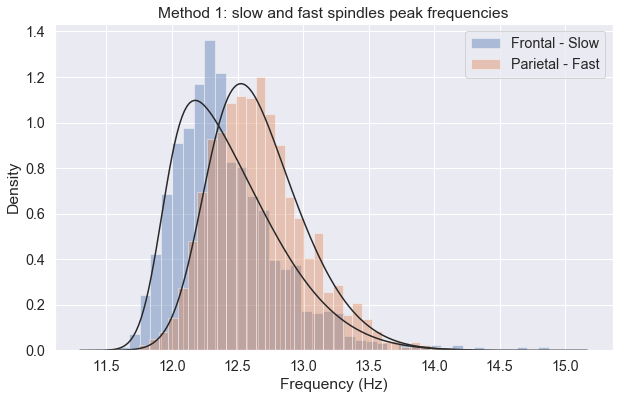

In [5]:
plt.figure(figsize=(10, 6))
sns.distplot(sp.loc[sp['Channel'].isin(['Fz', 'F3', 'F4']), 'Frequency'], kde=False, fit=skewnorm, label='Frontal - Slow')
sns.distplot(sp.loc[sp['Channel'].isin(['Pz', 'P3', 'P4']), 'Frequency'], kde=False, fit=skewnorm, label='Parietal - Fast')
plt.legend()
plt.title('Method 1: slow and fast spindles peak frequencies')
plt.xlabel('Frequency (Hz)')
_ = plt.ylabel('Density')

### Extract the fit parameters

In [6]:
_, slow_mu, slow_std = skewnorm.fit(sp.loc[sp['Channel'].isin(['Fz', 'F3', 'F4']), 'Frequency'])
_, fast_mu, fast_std = skewnorm.fit(sp.loc[sp['Channel'].isin(['Pz', 'P3', 'P4']), 'Frequency'])

print("Slow spindles (frontal) have a mean frequency of %.2f  Hz and a standard deviation of %.2f Hz" % (slow_mu, slow_std))
print("Fast spindles (parietal) have a mean frequency of %.2f Hz and a standard deviation of %.2f Hz" % (fast_mu, fast_std))

Slow spindles (frontal) have a mean frequency of 11.93  Hz and a standard deviation of 0.65 Hz
Fast spindles (parietal) have a mean frequency of 12.26 Hz and a standard deviation of 0.54 Hz


*****************

## Method 2: N2 sleep power spectrum peak detection

In this second part, we'll try to detect the slow and fast peak frequency *before* the actual spindles detection (a priori). This will help us tune the parameters of the spindles detection to be biased towards detecting slow or fast spindles.

**The steps are:**
1. Compute the power spectrum of N2 sleep for each channel
2. Identify the slow and fast peaks in the power spectrum
3. Run the spindles detection with the appropriate parameters

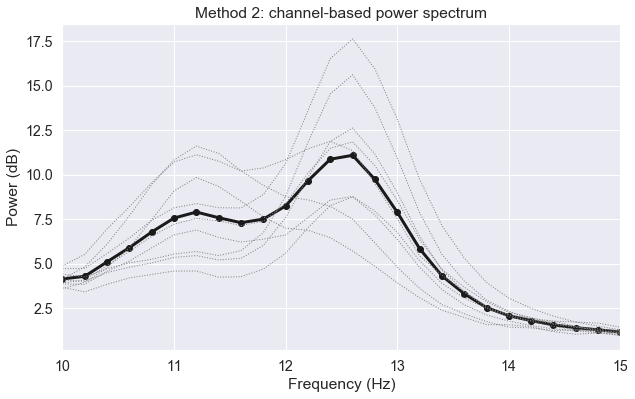

In [7]:
# Compute Welch spectrum of N2 sleep for each channel
f, pxx = welch(data[:, hypno == 2], sf, nperseg=(5 * sf))

# Convert to dB to reduce 1/f (optional)
# pxx = 10 * np.log10(pxx)

# Keep only frequencies of interest
pxx = pxx[:, np.logical_and(f >= 10, f <= 15)]
f = f[np.logical_and(f >= 10, f <= 15)]

# Plot average spectrum
plt.figure(figsize=(10, 6))
plt.plot(f, pxx.mean(0), 'ko-', lw=3)
plt.plot(f, np.rollaxis(pxx, axis=1), lw=1, ls=':', color='grey')
plt.xlim(10, 15)
plt.title('Method 2: channel-based power spectrum')
plt.xlabel('Frequency (Hz)')
_ = plt.ylabel('Power (dB)')

### Identify the two peaks in the power spectrum

In [8]:
idx_peaks, _ = find_peaks(pxx.mean(0))
print('Slow spindles peak frequency = %.2f Hz' % f[idx_peaks[0]])
print('Fast spindles peak frequency = %.2f Hz' % f[idx_peaks[1]])

Slow spindles peak frequency = 11.20 Hz
Fast spindles peak frequency = 12.60 Hz


*****************

## Method 3: Topography-based

This method is described in details in [Cox et al. 2017](https://www.frontiersin.org/articles/10.3389/fnhum.2017.00433/full). This method uses a *"spatial filtering approach that can reliably separate subject-specific spindle activity into slow and fast components"*:

> The spatial filters were defined by eigenvectors extracted from covariance matrices, similar to principal component analysis (PCA). In a spatial filtering context, the PCA procedure operates on a single channel-by-channel covariance matrix and produces eigenvectors pointing in orthogonal directions that explain decreasing amounts of variance. This approach, together with conceptually related ICA techniques, can be conceptualized as a “blind” source separation procedure, in that resulting components are not necessarily physiologically meaningful. In contrast, generalized eigendecomposition (GED) operates on two separate covariance matrices to find eigenvectors maximally differentiating the two. This may be viewed as a “guided” source separation procedure that spatially separates signal elements according to user-defined criteria. In our case, we constructed one covariance matrix from slow sigma-filtered data and one from fast sigma-filtered data.

**The steps are:**
1. Get the slow sigma-filtered data and fast sigma-filtered data
2. Detrend and compute the covariance matrices
3. Apply the generalized eigendecomposition to find eigenvectors that maximally differentiate between slow and fast spindles
4. Use the eigenvectors as spatial filters
5. Compute the Welch spectrum of N2 sleep on all the spatially filtered data (= components)
6. Find slow and fast peak frequencies by averaging the power spectrum of `n` components that are the most associated with slow and fast spindles, respectively.

**Important**
- The more clean and artefact-free channels you have, the better the identification will be.
- This is not a fully automatic method. You still need to select the number of components (see last step).

In [9]:
# Get filtered slow (10 - 12 Hz) and fast (12.5 - 15 Hz) data
slow_n2_filt = mne.filter.filter_data(data[:, hypno == 2].astype(np.float64), sf, 10, 12, 
                                      h_trans_bandwidth=1, l_trans_bandwidth=1, verbose=0)
fast_n2_filt = mne.filter.filter_data(data[:, hypno == 2].astype(np.float64), sf, 12.5, 15, 
                                      h_trans_bandwidth=1, l_trans_bandwidth=1, verbose=0)

In [10]:
# Remove the mean (= detrend)
slow_n2_filt = detrend(slow_n2_filt, type='constant')
fast_n2_filt = detrend(fast_n2_filt, type='constant')

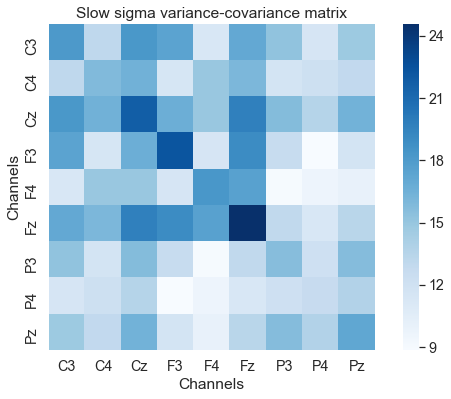

In [11]:
# Compute the covariance matrices between channels
slow_n2_cov = np.cov(slow_n2_filt)
fast_n2_cov = np.cov(fast_n2_filt)

# Plot the slow covariance matrix
plt.figure(figsize=(10, 6))
sns.heatmap(slow_n2_cov, cmap='Blues', square=True, 
            xticklabels=ch_names, yticklabels=ch_names)
plt.title('Slow sigma variance-covariance matrix')
plt.xlabel('Channels')
_ = plt.ylabel('Channels')

In [12]:
# Get the eigenvalues / eigenvectors
eigval, eigvec = eigh(slow_n2_cov, fast_n2_cov)

# Flip to descending order
eigval = np.flip(eigval)
eigvec = np.fliplr(eigvec)

print('Eigenvalues =', list(np.round(eigval, 2)))

Eigenvalues = [2.91, 2.42, 1.6, 1.36, 1.25, 1.14, 0.95, 0.79, 0.63]


In [13]:
# Apply spatial filters by multiplying data with eigenvectors
sf_comp_n2 = np.dot(data[:, hypno == 2].T, eigvec).T
print(sf_comp_n2.shape)

(9, 947925)


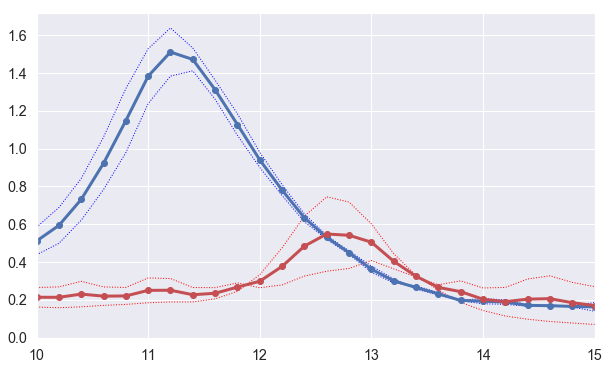

In [14]:
# Compute Welch spectrum of N2 sleep
f, pxx = welch(sf_comp_n2, sf, nperseg=(5 * sf))

pxx = pxx[:, np.logical_and(f >= 10, f <= 15)]
f = f[np.logical_and(f >= 10, f <= 15)]

# Convert to dB to reduce 1/f (optional)
# pxx = 10 * np.log10(pxx)

# Select the number of components to keep
n_comp = 2

# Plot first slow component
plt.figure(figsize=(10, 6))
plt.plot(f, np.rollaxis(pxx[:n_comp], axis=1), lw=1, ls=':', color='blue')
plt.plot(f, np.rollaxis(pxx[-n_comp:], axis=1), lw=1, ls=':', color='red')

# Plot average spectrum of four first / last components
plt.plot(f, pxx[:n_comp].mean(0), 'bo-', lw=3)
plt.plot(f, pxx[-n_comp:].mean(0), 'ro-', lw=3)
_ = plt.xlim(10, 15)

In [15]:
# Identify the peaks
print('Slow spindles peak frequency: %.2f Hz' % f[pxx[:n_comp].mean(0).argmax()])
print('Fast spindles peak frequency: %.2f Hz' % f[pxx[-n_comp:].mean(0).argmax()])

Slow spindles peak frequency: 11.20 Hz
Fast spindles peak frequency: 12.60 Hz


### Running the tuned spindles detection

Now that we have identified the two peaks, we can run the spindles detection with the tuned parameters.
For the sake of example, we add and remove 1 Hz to the slow and fast peak frequencies to detect the corresponding spindles types. However, this is purely arbitrary and you should experiment with other limits.

In [16]:
sp_slow = yasa.spindles_detect_multi(data, sf, ch_names, freq_sp=(10.20, 12.20))
# sp_fast = yasa.spindles_detect_multi(data, sf, ch_names, freq_sp=(11.60, 13.60))
print('%i spindles detected on %i channels.' % (sp_slow.shape[0], len(ch_names)))
sp_slow.head().round(3)

4582 spindles detected on 9 channels.


,Start,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Channel,IdxChannel
0,507.20,508.35,1.15,57.500,12.467,2.133,0.362,10.990,12.0,0.216,C3,0
1,526.28,526.79,0.51,66.805,19.147,2.703,0.307,10.986,5.0,0.462,C3,0
2,568.56,570.39,1.83,86.236,15.966,2.434,0.378,11.257,20.0,0.201,C3,0
3,588.22,589.04,0.82,58.043,12.203,2.097,0.355,10.967,9.0,0.506,C3,0
4,601.31,602.74,1.43,61.874,14.647,2.303,0.542,11.493,17.0,0.764,C3,0


*****************

## Summary

Some conclusions:

- Method 2 and method 3 yielded exactly the same results in this case (i.e. 11.20 Hz for slow spindles and 12.60 Hz for fast spindles).
- Method 1 returned slightly different results. This is probably caused by the fact that the frontal channels do not have exclusively slow spindles and the parietal channels exclusively fast spindles. Rather, there must be some level of contamination, which explains this "regression to the mean" effect that we observe in the two peaks detected with method 1.
- Method 3 is probably the most accurate, granted that you have enough clean and artefact-free channels. Note that in the original paper by Cox and colleagues, a surface Laplacian filter is also applied on the raw data to enhance spatial precision for topographical analyses.